In [1]:
import pandas as pd
import numpy as np
from itertools  import product
from joblib import Parallel,delayed
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing # 三指数平滑
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   # 单指数平滑
from statsmodels.tsa.holtwinters import Holt                 # 双指数平滑
from statsmodels.tsa.statespace.sarimax import SARIMAX       # 季节性自回归综合移动平均SARIMA
from sklearn import metrics
from warnings import catch_warnings,filterwarnings   # catch_warnings暂时禁止警告，filterwarnings在警告过滤器中插入一条数据项。默认情况下，该数据项将被插到前面；

import datetime
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
import seaborn as sns
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.stats.diagnostic import unitroot_adf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 全文忽略警告
import warnings
warnings.filterwarnings("ignore")

In [11]:
pd.set_option('display.max_columns',None)    # 显示所有列
pd.set_option('display.max_row',None)        # 显示所有行
pd.set_option('display.max_colwidth',1000)   # 打印不换行

In [2]:
# 数据导入和数据处理
all_data = pd.read_csv('./num_predict.csv')
all_data = all_data[~(all_data['numbers']==1)]
all_data['year'] = all_data['date'].map(lambda x: x.split('-')[0])
all_data['mon_day'] = all_data['date'].map(lambda x: x[5:])

# 保证每年的数据在相同的时间段内
everYear_min_date, everYear_max_date = [], []
for k in all_data['year'].unique():
    i_data = all_data[all_data['year']==k]
    everYear_min_date.append(min(i_data['mon_day']))
    everYear_max_date.append(max(i_data['mon_day']))
all_data = all_data[(all_data['mon_day']>=max(everYear_min_date)) & (all_data['mon_day']<=min(everYear_max_date))]
all_data.set_index('date',inplace=True)

# all_data.rename({'numbers': 'y'},axis='columns',inplace=True)
# all_data.insert(all_data.shape[1], 'store_code', 1)

print(all_data.shape)
all_data.head()

(192, 3)


,numbers,year,mon_day
date,,,
2016-09-06,22.0,2016,09-06
2016-09-07,26.0,2016,09-07
2016-09-08,29.0,2016,09-08
2016-09-09,24.0,2016,09-09
2016-09-10,35.0,2016,09-10


In [3]:
# 2016-2020的数据
data_2016_2020 = list(all_data[~(all_data['year']=='2021')]['numbers'].values)
data_2d_2016_2020 = all_data[~(all_data['year']=='2021')]
# 2021的数据
data_2021 = list(all_data[all_data['year']=='2021']['numbers'].values)
# 全部数据
all_data_list = list(all_data['numbers'].values)

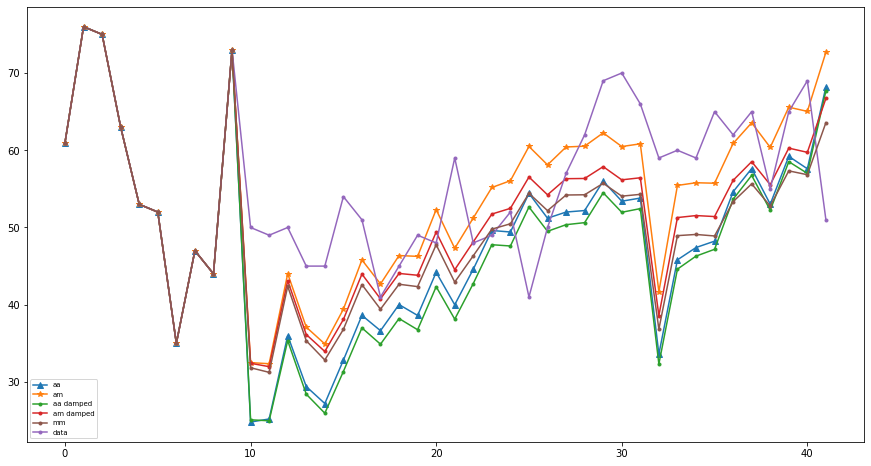

In [13]:
# 三指数平滑预测
fit1 = ExponentialSmoothing(data_2016_2020, seasonal_periods=32, trend='add', seasonal='add').fit()
fit2 = ExponentialSmoothing(data_2016_2020, seasonal_periods=32, trend='add', seasonal='mul').fit()
fit3 = ExponentialSmoothing(data_2016_2020, seasonal_periods=32, trend='add', seasonal='add', damped=True).fit()
fit4 = ExponentialSmoothing(data_2016_2020, seasonal_periods=32, trend='add', seasonal='mul', damped=True).fit()
fit5 = ExponentialSmoothing(data_2016_2020, seasonal_periods=32, trend='mul', seasonal='mul', damped=True).fit()

plt.figure(figsize=(15, 8))

l1, = plt.plot(data_2016_2020[150:] + list(fit1.forecast(32)), marker='^')
l2, = plt.plot(data_2016_2020[150:] + list(fit2.forecast(32)), marker='*')
l3, = plt.plot(data_2016_2020[150:] + list(fit3.forecast(32)), marker='.')
l4, = plt.plot(data_2016_2020[150:] + list(fit4.forecast(32)), marker='.')
l6, = plt.plot(data_2016_2020[150:] + data_2021, marker='.')
l5, = plt.plot(data_2016_2020[150:] + list(fit5.forecast(32)), marker='.')

plt.legend(handles = [l1, l2, l3, l4, l5, l6], 
           labels = ["aa", "am", "aa damped", "am damped","mm","data"], 
           loc = 'best', 
           prop={'size': 7})

plt.show()

In [7]:
def mape_fun(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

def smape_fun(y_true, y_pred):
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100

In [9]:
def assess(predict_data):
    # 均方误差
    mse = metrics.mean_squared_error(data_2021, predict_data)
    print('均方误差MSE:', mse)
    # 均方根误差
    rmse = np.sqrt(metrics.mean_squared_error(data_2021, predict_data))
    print('均方根误差RMSE:', rmse)
    # 平均绝对误差
    mae = metrics.mean_absolute_error(data_2021, predict_data)
    print('平均绝对误差MAE:', mae)
    # 平均绝对百分比误差
    mape = mape_fun(data_2021, predict_data)
    print('平均绝对百分比误差MAPE:', mape)
    # 对称平均绝对百分比误差
    smape = smape_fun(data_2021, predict_data)
    print('对称平均绝对百分比误差SMAPE:', smape)

In [12]:
for i,v in enumerate([fit1,fit2,fit3,fit4,fit5]):
    print('当前对象：fit%d'%(i+1))
    print(assess(v.forecast(32)))

当前对象：fit1
均方误差MSE: 182.3003470501992
均方根误差RMSE: 13.501864576798244
平均绝对误差MAE: 11.541693129087097
平均绝对百分比误差MAPE: 21.24469865948942
对称平均绝对百分比误差SMAPE: 24.410352136655277
None
当前对象：fit2
均方误差MSE: 87.9035179654673
均方根误差RMSE: 9.375687599609284
平均绝对误差MAE: 7.36223089722386
平均绝对百分比误差MAPE: 14.053366678675472
对称平均绝对百分比误差SMAPE: 14.527807784316064
None
当前对象：fit3
均方误差MSE: 205.44567812423782
均方根误差RMSE: 14.333376368610356
平均绝对误差MAE: 12.555858308717223
平均绝对百分比误差MAPE: 23.080345295583246
对称平均绝对百分比误差SMAPE: 26.804327014142217
None
当前对象：fit4
均方误差MSE: 101.85109432140547
均方根误差RMSE: 10.092130316311094
平均绝对误差MAE: 8.229751861532534
平均绝对百分比误差MAPE: 15.011289641719802
对称平均绝对百分比误差SMAPE: 16.259090326522458
None
当前对象：fit5
均方误差MSE: 123.45352277864808
均方根误差RMSE: 11.110964079621898
平均绝对误差MAE: 9.398470552450789
平均绝对百分比误差MAPE: 16.914260678912804
对称平均绝对百分比误差SMAPE: 18.71983674683492
None
